In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 26})

import sys
sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

from misc import pearson_r, get_best_models, highlight_ns, model_alias, model_bar_colors, dna_models

%load_ext autoreload
%autoreload 2

In [2]:
project_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

In [3]:
cell_types = ['HEK293FT', 'HMEC', 'HEPG2', 'GM12878', 'K562', 'SKNSH']

## Combine regression output

In [4]:
models = ['DNABERT','DNBT-3UTR-RNA','DNABERT2','DNABERT2-ZOO','DNBT2-3UTR-RNA','NT-MS-v2-100M',
         'NT-3UTR-RNA','STSP-3UTR-RNA','STSP-3UTR-RNA-SA','STSP-3UTR-DNA','STSP-3UTR-RNA-HS','Griesemer et al., 2021']

In [5]:
res = []

#POSITIONS are 0-based
utr_variants = pd.read_csv(project_dir + 'mpra/griesemer_2021/preprocessing/GRCh38_UTR_variants.tsv', sep='\t') #all positions are 0-based [start, end)
utr_variants = utr_variants[['oligo_id','var_start','ref', 'alt','oligo_start','oligo_end','strand']]
utr_variants = utr_variants.rename(columns={'var_start':'pos','oligo_start':'seq_start','oligo_end':'seq_end'})

for regressor in ('Ridge','SVR'):
    print(regressor)
    results_dir = project_dir + f'mpra/griesemer_2021/predictions/{regressor}/'
    for cell_type in cell_types:
        for model in models:
                res_tsv = results_dir + f'{cell_type}-{model_alias[model]}.tsv'
                if os.path.isfile(res_tsv):
                    df = pd.read_csv(res_tsv, sep='\t')
                    df = df.merge(utr_variants,validate='1:1')
                    df['model'] = model
                    df['cell_type'] = cell_type
                    df['regressor'] = regressor
                    res.append(df)

res = pd.concat(res).rename(columns={'Expression':'y_true','group':'fold'})


res[['pos','oligo_start','oligo_end']] = res[['pos','seq_start','seq_end']].astype(int)

res = res.drop(columns=['seq_start','seq_end']).rename(columns={'cell_type':'cell_line'})

res = res[['fold','chrom','pos','mpra_variant_id','ref', 'alt','oligo_id','oligo_start','oligo_end','strand',
           'regressor','cell_line','model','y_true','y_pred']]

Ridge
SVR


In [6]:
res.loc[res.model.isin(dna_models),'fasta_file'] = 'mpra/griesemer_2021/fasta/variants_dna_fwd.fa'
res.loc[~res.model.isin(dna_models),'fasta_file'] = 'mpra/griesemer_2021/fasta/variants_rna.fa'

In [7]:
res.groupby(['regressor','cell_line']).model.count()//res.model.nunique()

regressor  cell_line
Ridge      GM12878      14264
           HEK293FT     14262
           HEPG2        14264
           HMEC         14264
           K562         14264
           SKNSH        14264
SVR        GM12878      12558
           HEK293FT     14262
           HEPG2        12558
           HMEC         13411
           K562         13411
           SKNSH        12558
Name: model, dtype: int64

In [8]:
res.to_csv(project_dir + 'all_scores/mpra_griesemer_2021.tsv.gz',sep='\t',index=None)

## Compute summary statistics

In [15]:
models = ['DNABERT','DNBT-3UTR-RNA','DNABERT2','DNABERT2-ZOO','DNBT2-3UTR-RNA','NT-MS-v2-100M',
         'NT-3UTR-RNA','STSP-3UTR-RNA','STSP-3UTR-RNA-HS','STSP-3UTR-DNA','Griesemer et al., 2021']

In [16]:
res = pd.read_csv(project_dir + 'all_scores/mpra_griesemer_2021.tsv.gz',sep='\t')

res = res[res.model.isin(models)]

/tmp/ipykernel_3793940/4098898082.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  res = pd.read_csv(project_dir + 'all_scores/mpra_griesemer_2021.tsv.gz',sep='\t')


In [17]:
scores_df = res.groupby(['regressor','model','cell_line']).apply(lambda x:pearson_r(x.y_true,x.y_pred,compute_CI=True),include_groups=False).rename('pearson_r').reset_index()
scores_df.pearson_r = scores_df.pearson_r.apply(lambda x: (round(x[0],2),round(x[1],2)))

best_models = scores_df.set_index('model').groupby(['regressor','cell_line']).pearson_r.apply(get_best_models)
scores_df = scores_df.pivot(index=['regressor','model'],columns=['cell_line']).droplevel(0,axis=1)
scores_df = scores_df.map(lambda x: f'{x[0]:.2f}±{x[1]:.2f}' if isinstance(x,tuple) else 'none')

In [18]:
scores_df.loc['Ridge'].loc[models].style.apply(lambda x: highlight_ns(x, best_models.loc['Ridge']))

cell_line,GM12878,HEK293FT,HEPG2,HMEC,K562,SKNSH
model,,,,,,
DNABERT,0.28±0.01,0.17±0.02,0.27±0.01,0.38±0.01,0.23±0.01,0.22±0.01
DNBT-3UTR-RNA,0.38±0.01,0.32±0.01,0.35±0.01,0.51±0.01,0.35±0.01,0.34±0.01
DNABERT2,0.11±0.02,0.10±0.02,0.13±0.02,0.31±0.01,0.18±0.01,0.15±0.02
DNABERT2-ZOO,0.12±0.02,0.08±0.02,0.14±0.02,0.31±0.01,0.15±0.02,0.11±0.02
DNBT2-3UTR-RNA,0.29±0.01,0.20±0.01,0.28±0.01,0.46±0.01,0.29±0.01,0.27±0.01
NT-MS-v2-100M,0.14±0.02,0.12±0.02,0.16±0.02,0.32±0.01,0.20±0.01,0.18±0.02
NT-3UTR-RNA,0.29±0.01,0.24±0.01,0.28±0.01,0.46±0.01,0.30±0.01,0.28±0.01
STSP-3UTR-RNA,0.40±0.01,0.30±0.01,0.38±0.01,0.50±0.01,0.34±0.01,0.32±0.01
STSP-3UTR-RNA-HS,0.35±0.02,0.22±0.02,0.37±0.02,0.45±0.02,0.29±0.02,0.26±0.02


In [19]:
scores_df.loc['SVR'].loc[models].style.apply(lambda x: highlight_ns(x, best_models.loc['SVR']))

cell_line,GM12878,HEK293FT,HEPG2,HMEC,K562,SKNSH
model,,,,,,
DNABERT,0.35±0.01,0.22±0.01,0.35±0.01,0.44±0.01,0.28±0.01,0.26±0.01
DNBT-3UTR-RNA,0.46±0.01,0.34±0.01,0.44±0.01,0.55±0.01,0.38±0.01,0.37±0.01
DNABERT2,0.27±0.01,0.16±0.02,0.26±0.01,0.37±0.01,0.23±0.01,0.21±0.01
DNABERT2-ZOO,0.24±0.01,0.13±0.02,0.23±0.01,0.35±0.01,0.20±0.01,0.18±0.02
DNBT2-3UTR-RNA,0.40±0.01,0.25±0.01,0.39±0.01,0.49±0.01,0.32±0.01,0.31±0.01
NT-MS-v2-100M,0.26±0.01,0.17±0.02,0.26±0.01,0.37±0.01,0.24±0.01,0.22±0.01
NT-3UTR-RNA,0.41±0.01,0.31±0.01,0.41±0.01,0.51±0.01,0.36±0.01,0.34±0.01
STSP-3UTR-RNA,0.53±0.02,0.39±0.01,0.54±0.02,0.56±0.02,0.39±0.01,0.39±0.02
STSP-3UTR-RNA-HS,0.52±0.02,0.30±0.02,0.52±0.02,0.54±0.02,0.38±0.02,0.36±0.02


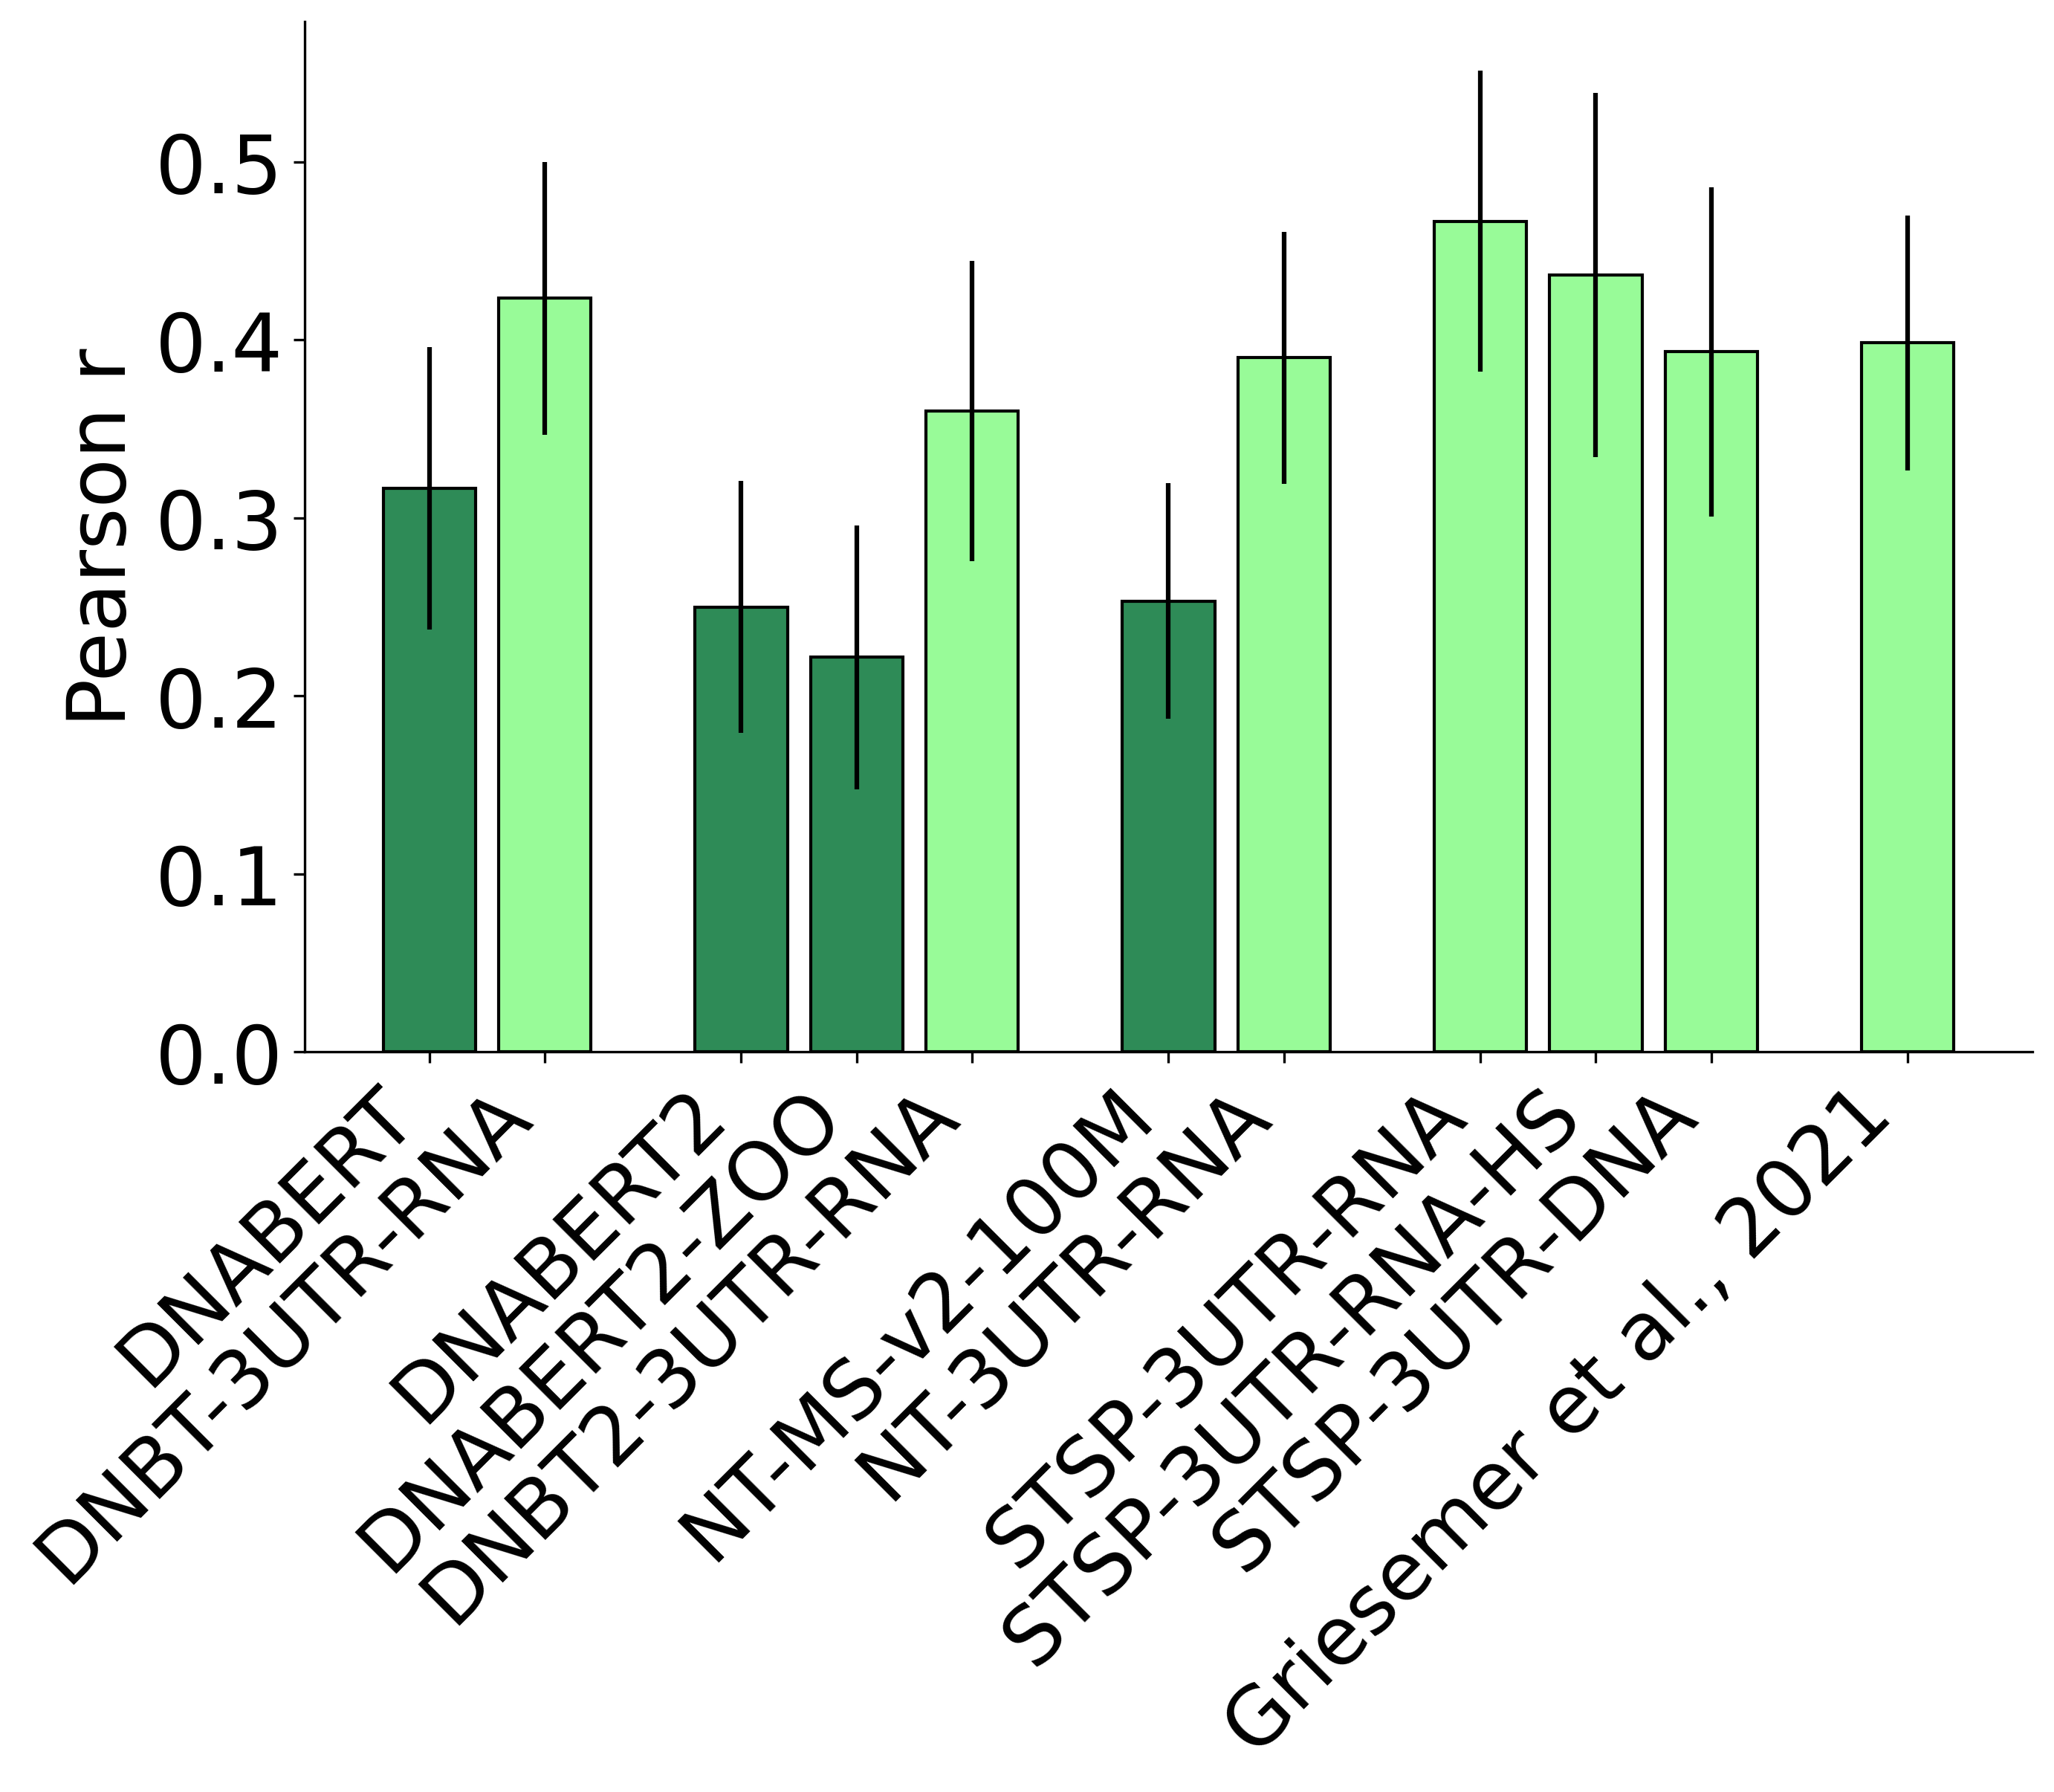

In [20]:
df = scores_df.loc['SVR'].loc[models].map(lambda x:float(x.split('±')[0]))

fig, ax = plt.subplots(dpi=300, figsize=(10,6))

offset = 0

xticks = []
for idx, (model, corr) in enumerate(df.iterrows()):
    if model in ('DNABERT2','NT-MS-v2-100M','STSP-3UTR-RNA','Griesemer et al., 2021'):
        offset+=0.7
    ax.bar(offset+idx, corr.mean(), yerr=corr.std(), color=model_bar_colors[model], edgecolor='black')
    xticks.append(offset+idx)

#xticklabels = [x if x in ('DNABERT','DNABERT-2','NT-MS-v2-100M') else r'\textbf{' + x + '}' for x in df.index]
    
ax.set_xticks(xticks, df.index, rotation=45, ha="right");

#for lab in ax.get_xticklabels():
#   if lab.get_text()  in ('DNABERT','DNABERT-2','NT-MS-v2-100M'):
#      lab.set_fontweight('heavy')
       
ax.set_ylabel('Pearson r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)